In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle

# load sae features

In [ ]:
file_path = '/content/drive/MyDrive/fActs_ts_1L_21M.pkl'
with open(file_path, 'rb') as f:
    feature_acts_model_A = pickle.load(f)

In [ ]:
file_path = '/content/drive/MyDrive/fActs_ts_2L_33M.pkl'
with open(file_path, 'rb') as f:
    feature_acts_model_B = pickle.load(f)

# cosine sim mat

In [ ]:
first_dim_reshaped = feature_acts_model_A.shape[0] * feature_acts_model_A.shape[1]
reshaped_activations_A = feature_acts_model_A.reshape(first_dim_reshaped, feature_acts_model_A.shape[-1]).cpu()
reshaped_activations_B = feature_acts_model_B.reshape(first_dim_reshaped, feature_acts_model_B.shape[-1]).cpu()

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Transpose the activations to get F vectors of size N and F_2 vectors of size N
actvs1_T = reshaped_activations_A.T  # shape (F, N)
actvs2_T = reshaped_activations_B.T  # shape (F_2, N)

# Calculate cosine similarity between every F vector and every F_2 vector
cosine_sim_matrix = cosine_similarity(actvs1_T, actvs2_T)  # shape (F, F_2)

In [ ]:
cosine_sim_matrix.shape

(16384, 16384)

In [ ]:
cosine_sim_matrix

array([[0.        , 0.        , 0.03928287, ..., 0.00012136, 0.        ,
        0.00970324],
       [0.01625915, 0.01151919, 0.00710769, ..., 0.00534076, 0.        ,
        0.02665847],
       [0.00088282, 0.        , 0.00389133, ..., 0.00285131, 0.        ,
        0.00084877],
       ...,
       [0.        , 0.00315497, 0.08262642, ..., 0.03892154, 0.        ,
        0.00020643],
       [0.        , 0.        , 0.01086261, ..., 0.        , 0.        ,
        0.00738775],
       [0.        , 0.        , 0.01335653, ..., 0.00029775, 0.        ,
        0.01416768]], dtype=float32)

In [ ]:
import numpy as np

def find_top_features(cosine_sim_matrix, top_n=3):
    """
    Finds the top N features in B for each feature in A and vice versa.

    Args:
    - cosine_sim_matrix (numpy.ndarray): Cosine similarity matrix of shape (F, F_2)
    - top_n (int): Number of top features to find. Default is 3.

    Returns:
    - top_features_A_to_B (dict): Dictionary where keys are indices of features in A,
                                  and values are lists of indices of top features in B.
    - top_features_B_to_A (dict): Dictionary where keys are indices of features in B,
                                  and values are lists of indices of top features in A.
    """
    F, F_2 = cosine_sim_matrix.shape

    # Find top N features in B for each feature in A
    top_features_A_to_B = {}
    # for i in range(F):
    for i in range(5):
        top_features_A_to_B[i] = np.argsort(cosine_sim_matrix[i])[-top_n:][::-1]

    # Find top N features in A for each feature in B
    top_features_B_to_A = {}
    # for j in range(F_2):
    for j in range(5):
        top_features_B_to_A[j] = np.argsort(cosine_sim_matrix[:, j])[-top_n:][::-1]

    return top_features_A_to_B, top_features_B_to_A

# Find top 3 features
top_features_A_to_B, top_features_B_to_A = find_top_features(cosine_sim_matrix)

print("Top features in B for each feature in A:")
for feature_A, top_features_B in top_features_A_to_B.items():
    print(f"Feature {feature_A} in A: Top features in B - {top_features_B}")

print("\nTop features in A for each feature in B:")
for feature_B, top_features_A in top_features_B_to_A.items():
    print(f"Feature {feature_B} in B: Top features in A - {top_features_A}")


Top features in B for each feature in A:
Feature 0 in A: Top features in B - [ 3630 10756 11301]
Feature 1 in A: Top features in B - [13124 12183  9748]
Feature 2 in A: Top features in B - [ 3198 13665 12511]
Feature 3 in A: Top features in B - [ 5157  2545 16341]
Feature 4 in A: Top features in B - [15156 13906  2755]

Top features in A for each feature in B:
Feature 0 in B: Top features in A - [15150 10536  6809]
Feature 1 in B: Top features in A - [ 3553 11470  5078]
Feature 2 in B: Top features in A - [12167  2789 14840]
Feature 3 in B: Top features in A - [ 1540 10583  3954]
Feature 4 in B: Top features in A - [ 8931  6591 12219]


In [ ]:
# Find the highest cosine similarity value
highest_cosine_sim = np.max(cosine_sim_matrix)

# Find the indices of the vectors that have the highest cosine similarity
indices = np.unravel_index(np.argmax(cosine_sim_matrix, axis=None), cosine_sim_matrix.shape)
highest_cosine_sim_vectors = (indices[0], indices[1])  # (index in actvs1_T, index in actvs2_T)

print("Highest Cosine Similarity:", highest_cosine_sim)
print("Indices of highest similarity vectors:", highest_cosine_sim_vectors)

Highest Cosine Similarity: 1.0000001
Indices of highest similarity vectors: (3383, 565)


In [ ]:
def find_top_pairs(cosine_sim_matrix, top_n=5):
    """
    Finds the top N pairs of features with the highest cosine similarity.

    Args:
    - cosine_sim_matrix (numpy.ndarray): Cosine similarity matrix of shape (F, F_2)
    - top_n (int): Number of top pairs to find. Default is 5.

    Returns:
    - top_pairs (list of tuples): List of tuples where each tuple contains
                                  (index of feature in A, index of feature in B, cosine similarity value)
    """
    # Flatten the matrix and get the indices of the top N highest values
    flat_indices = np.argsort(cosine_sim_matrix, axis=None)[-top_n:][::-1]

    # Convert flat indices back to 2D indices
    top_pairs = []
    for idx in flat_indices:
        i, j = np.unravel_index(idx, cosine_sim_matrix.shape)
        top_pairs.append((i, j, cosine_sim_matrix[i, j]))

    return top_pairs

top_pairs = find_top_pairs(cosine_sim_matrix)

print("Top 5 pairs with the highest cosine similarity:")
for feature_A, feature_B, sim in top_pairs:
    print(f"Feature {feature_A} in A and Feature {feature_B} in B: Cosine similarity = {sim}")

Top 5 pairs with the highest cosine similarity:
Feature 3383 in A and Feature 14535 in B: Cosine similarity = 1.0000001192092896
Feature 8341 in A and Feature 4894 in B: Cosine similarity = 1.0000001192092896
Feature 8341 in A and Feature 638 in B: Cosine similarity = 1.0000001192092896
Feature 3383 in A and Feature 9100 in B: Cosine similarity = 1.0000001192092896
Feature 8341 in A and Feature 13822 in B: Cosine similarity = 1.0000001192092896


In [ ]:
model_A_f_ind = 3383
model_B_f_ind = 14535

feature_0_actvs_A = reshaped_activations_A[:, model_A_f_ind].numpy()
feature_0_actvs_B = reshaped_activations_B[:, model_B_f_ind].numpy()

In [ ]:
feature_0_actvs_A.shape

(16384,)

In [ ]:
cosine_sim_matrix[model_A_f_ind][model_B_f_ind]

1.0000001

In [ ]:
np.corrcoef(feature_0_actvs_A, feature_0_actvs_B)

array([[1., 1.],
       [1., 1.]])

In [ ]:
def count_nonzero_features(feature_acts):
    # Count the number of 0s in the tensor
    num_zeros = (feature_acts == 0).sum().item()

    # Count the number of nonzeroes in the tensor
    num_ones = (feature_acts > 0).sum().item()

    # Calculate the percentage of 1s over 0s
    if num_zeros > 0:
        perc_ones_over_total = (num_ones / (num_ones + num_zeros)) * 100
    else:
        perc_ones_over_total = float('inf')  # Handle division by zero
    # return perc_ones_over_total
    return num_ones, num_zeros

In [ ]:
feature_0_actvs_A

array([0.01403481, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ], dtype=float32)

In [ ]:
count_nonzero_features(feature_0_actvs_A)

(32, 16352)

In [ ]:
feature_0_actvs_B

array([0.03616735, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ], dtype=float32)

In [ ]:
count_nonzero_features(feature_0_actvs_B)

(32, 16352)

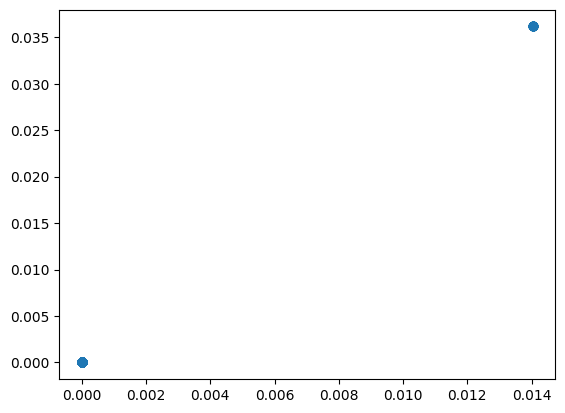

In [ ]:
plt.scatter(feature_0_actvs_A, feature_0_actvs_B, alpha=0.5)

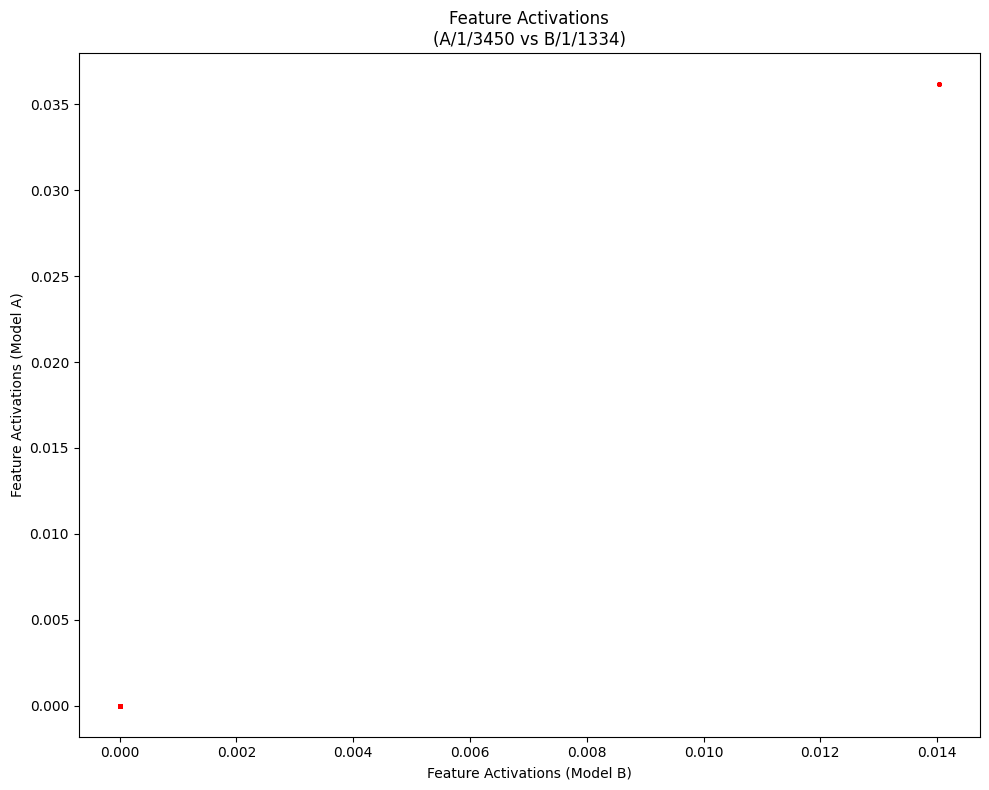

In [ ]:
import matplotlib.pyplot as plt

# Calculate correlation
correlation = np.corrcoef(feature_0_actvs_A, feature_0_actvs_B)[0, 1]

# Create the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(feature_0_actvs_A, feature_0_actvs_B, alpha=0.5, color='red', s=5)

# Set labels and title
plt.xlabel('Feature Activations (Model B)')
plt.ylabel('Feature Activations (Model A)')
plt.title('Feature Activations\n(A/1/3450 vs B/1/1334)')

# Add correlation text
# plt.text(0.05, 0.95, f'Correlation={correlation:.2f}',
#          transform=plt.gca().transAxes,
#          bbox=dict(facecolor='orange', alpha=0.5),
#          verticalalignment='top')

# Add histograms on the sides
# left, bottom, width, height = [0.68, 0.68, 0.2, 0.2]
# ax2 = plt.axes([left, bottom, width, height])
# ax2.hist(feature_0_actvs_B, bins=50, orientation='vertical', color='red', alpha=0.5)
# ax2.axis('off')

# left, bottom, width, height = [0.1, 0.1, 0.2, 0.58]
# ax3 = plt.axes([left, bottom, width, height])
# ax3.hist(feature_0_actvs_A, bins=50, orientation='horizontal', color='red', alpha=0.5)
# ax3.axis('off')

plt.tight_layout()
plt.show()